In [1]:
from IPython.core.display import HTML, display
import pickle
from warnings import filterwarnings

import pymc3 as pm
import theano.tensor as tt
from theano import shared

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from seaborn import heatmap
import matplotlib.pyplot as pl
from matplotlib import rcParams
from cmocean import cm as cmo

from pymc_utils import PyMCModel
from pymc_utils import Ordered
from pymc_utils import subset_significant_feature
from pymc_utils import plot_fits_with_unc

import os
# one of
os.environ['MKL_THREADING_LAYER'] = 'sequential'
#os.environ['OMP_NUM_THREADS'] = '1'
#os.environ['MKL_THREADING_LAYER'] = 'GNU'

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
filterwarnings('ignore', category=UserWarning)

In [3]:
display(HTML("<style>.container {width: 90% !important}</style>"))

In [4]:
% matplotlib inline
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16

In [5]:
# Plot Fits with Uncertainty Estimates
def plot_fits_with_unc(y_obs, ppc_, ax=None):
    iy  = np.argsort(y_obs)
    ix = np.arange(iy.size)
    lik_mean =ppc_.mean(axis=0)
    lik_hpd = pm.hpd(ppc_)
    lik_hpd_05 = pm.hpd(ppc_, alpha=0.5)
    if ax is None:
        _, ax = pl.subplots(figsize=(12, 8))
        ax.scatter(ix, y_obs.values[iy], label='observed', edgecolor='k', s=50,
                   color='steelblue');
        ax.scatter(ix, lik_mean[iy], label='modeled', edgecolor='k', s=50, color='m')

        ax.fill_between(ix, y1=lik_hpd_05[iy, 0], y2=lik_hpd_05[iy, 1], alpha=0.5, color='k',
                       label='model output 50%CI');
        ax.fill_between(ix, y1=lik_hpd[iy, 0], y2=lik_hpd[iy, 1], alpha=0.5, color='k',
                       label='model output 95%CI');
        ax.legend(loc='upper left');
    return ax

In [19]:
def bayes_nn_l2(X, y_obs, n_hidden, lklhd_name='likelihood',):
    """
    Hierarchical Bayesian NN Implementation.
    
    Inputs:
    --------
    X: theano shared variable,
    y_obs: numpy vector,
    n_hidden: tuple, unit number for each HL,
    lklhd_name: name of the likelihood variable.
    
    Output:
    --------
    PyMC3 model
    """
    X = pm.floatX(X)
    Y = pm.floatX(y_obs)
    n_hidden1, n_hidden2 = n_hidden
    if hasattr(X, 'name'):
        num_obs, num_feats = X.eval().shape
    else:
        num_obs, num_feats = X.shape
    
    testvals_b1 = np.sort(np.random.randn(n_hidden1))
    testvals_b2 = np.sort(np.random.randn(n_hidden2))
                          
    
    with pm.Model() as model:
        
        hyper_b1_sd = pm.Exponential('hyper_b1_sd', lam=.1)
        #hyper_b2_sd = pm.Exponential('hyper_b2_sd', lam=.1)
        #hyper_b3_sd = pm.Exponential('hyper_b3_sd', lam=.1)
        hyper_w1_sd = pm.Exponential('hyper_w1_sd', lam=.1, shape=(num_feats, 1))
        #hyper_w2_sd = pm.Exponential('hyper_w2_sd', lam=.1,)
        #hyper_w3_sd = pm.Exponential('hyper_w3_sd', lam=.1)
        
        
        b1_pre = pm.Normal('b1_pre', mu=0, sd=hyper_b1_sd, shape=(n_hidden1),
                           transform=Ordered(), testval=testvals_b1)
        #b2_pre = pm.Normal('b2_pre', mu=0, sd=1, shape=(n_hidden2),
                           #transform=Ordered(), testval=testvals_b2)
        
        
        b1 = pm.Deterministic('bias_layer1', b1_pre * hyper_b1_sd)
        #b2 = pm.Deterministic('bias_layer2', b2_pre * hyper_b2_sd)
        b2 = pm.Normal('bias_layer2', mu=0, sd=1, shape=(n_hidden2), 
                      transform=Ordered(), testval=testvals_b2)
        b3 = pm.Normal('bias_layer3', mu=0, sd=1)
        
        #w1_pre = pm.Normal('w1_pre', mu=0, sd=1, shape=(num_feats, n_hidden1))
        #w2_pre = pm.Normal('w2_pre', mu=0, sd=1, shape=(n_hidden1, n_hidden2))
        #w3_pre = pm.Normal('w3_pre', mu=0, sd=1, shape=(n_hidden2,))
        
        #w1 = pm.Deterministic('wts_i_1', w1_pre * hyper_w1_sd)
        w1 = pm.Normal('wts_i_1', mu=0, sd=hyper_w1_sd, shape=(num_feats, n_hidden1))
        #w2 = pm.Normal('wts_1_2', mu=0, sd=hyper_w2_sd, shape=(n_hidden1, n_hidden2))
        #w3 = pm.Normal('wts_2_out', mu=0, sd=hyper_w3_sd, shape=(n_hidden2,))
        w2 = pm.Normal('wts_1_2', mu=0, sd=1, shape=(n_hidden1, n_hidden2))
        w3 = pm.Normal('wts_2_out', mu=0, sd=1, shape=n_hidden2)
        
        #w2 = pm.Deterministic('wts_1_2', w2_pre * hyper_w2_sd)
        #3 = pm.Deterministic('wts_2_out', w3_pre * hyper_w3_sd)
        
        lyr1_act = pm.Deterministic('layer1_act', tt.nnet.elu(tt.dot(X, w1) + b1))
        lyr2_act = pm.Deterministic('layer2_act', tt.nnet.elu(tt.dot(lyr1_act, w2) + b2))
        out_act = pm.Deterministic('layer3_act', tt.dot(lyr2_act, w3) + b3)
        
        sd = pm.HalfCauchy('sd', beta=1)
        output = pm.Normal(lklhd_name, mu=out_act, sd=sd, observed=Y)
    return model

In [6]:
ds = pd.read_pickle('./pickleJar/OperationalDataSets/df_6_APHY_Standardized_SWF.pkl')
#ds['log10_aphy%d' % band] = np.log10(ds.loc[:, 'aphy%d' % band])
#ds.to_pickle('./pickleJar/OperationalDataSets/df_6_APHY_Standardized_SWF.pkl')

In [7]:
ds.describe().T

,count,mean,std,min,25%,50%,75%,max
sin_doy_s,162.0,-7.538551e-17,1.003101,-1.632361,-1.075398,0.291772,0.919767,1.067988
cos_doy_s,162.0,3.807825e-17,1.003101,-1.729100,-0.778317,0.208898,0.685304,1.430161
sin_minofday_s,162.0,1.915477e-16,1.003101,-0.599067,-0.553291,-0.397313,0.053463,4.165531
cos_minofday_s,162.0,-2.193033e-17,1.003101,-1.835295,-0.763772,0.101973,0.788677,2.063419
x_s,162.0,-1.045117e-16,1.003101,-2.523305,0.067800,0.101626,0.322978,2.480050
y_s,162.0,-6.030841e-17,1.003101,-0.570194,-0.540412,-0.281825,-0.081228,4.415726
z_s,162.0,-1.096945e-16,1.003101,-4.151014,0.121210,0.153920,0.480512,1.370943
log10_etopo2_s,162.0,-1.398059e-16,1.003101,-1.962412,-0.768789,-0.369002,0.760279,1.745110
oisst_s,162.0,2.193033e-17,1.003101,-2.990826,-0.781122,0.070849,0.976256,1.396973
solz_s,162.0,-1.072530e-16,1.003101,-1.851402,-0.753258,0.127265,0.760037,1.757741


In [8]:
feat_beg = 'sin_doy_s'
feat_end_ni = 'PC6_s'

X_s = ds.drop(['sin_minofday_s', 'cos_minofday_s'], axis=1).dropna().loc[:, :feat_end_ni]
lbls_X_s = X_s.columns.tolist()
y_all = ds.dropna().filter(regex='log10_a')

In [9]:
X_s_train, X_s_test, y_train_all, y_test_all = train_test_split(X_s, y_all, test_size=0.1,
                                                                random_state=42)
Xy_train = pd.concat((X_s_train, y_train_all), axis=1)

In [10]:
def plot_pairwise_corr(df_, ax=None, **heatmap_kwds):
    if ax is None:
        _, ax = pl.subplots(figsize=(12, 10))
    heatmap(df_.corr().iloc[1:,:-1],vmin=-1, vmax=1,
            mask=np.triu(np.ones([df_.shape[1]-1] * 2),k=1),
            ax=ax, annot=True, annot_kws={'fontsize': 10}, **heatmap_kwds)
    ax.set_facecolor('k')
    return ax

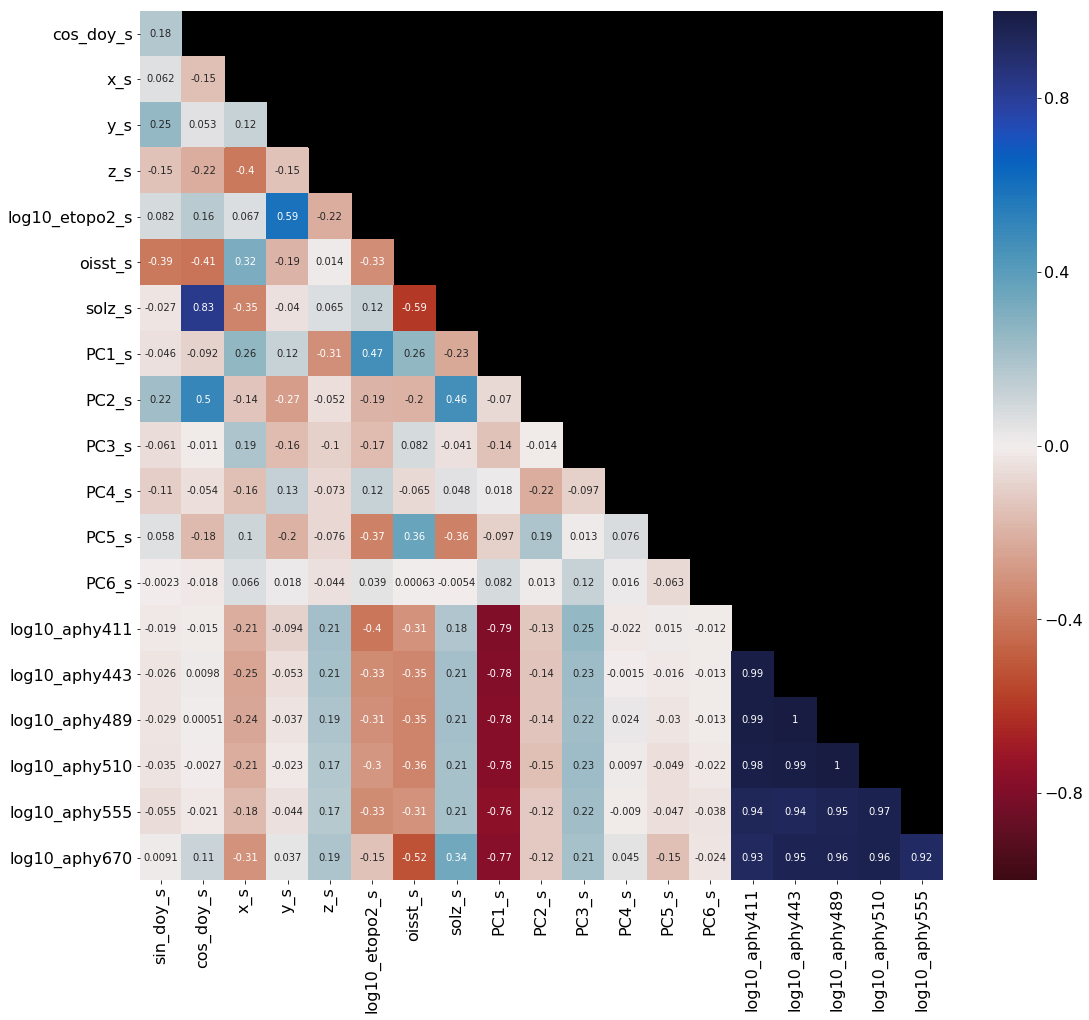

In [11]:
f, ax = pl.subplots(figsize=(18, 16))
plot_pairwise_corr(pd.concat((X_s, y_all), axis=1), ax=ax, cmap=cmo.balance_r);

### Fitting w/ All Features

####  <u>Model 1: 2-Hidden Layer BNN -- 4 units/HL</u>

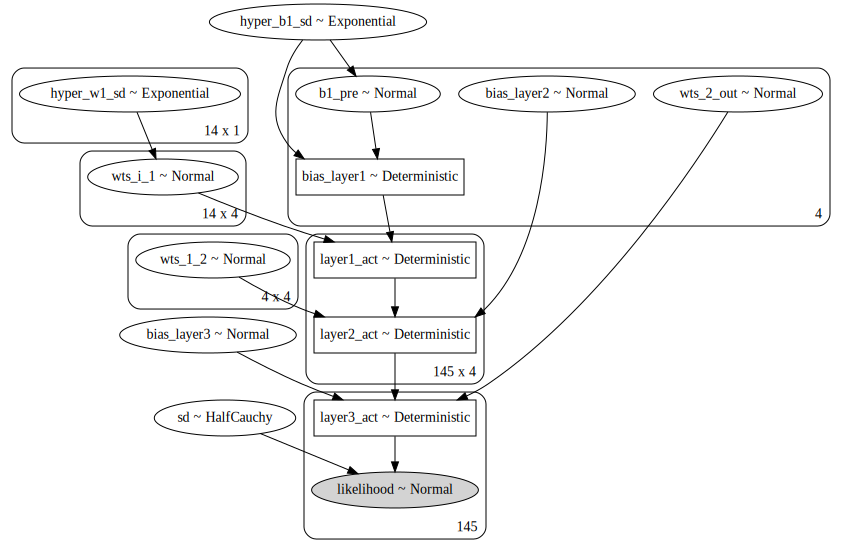

In [20]:
X_shared = shared(X_s_train.values)
bnn_l2_4_4HL_411 = PyMCModel(bayes_nn_l2, X_shared, y_train_all.log10_aphy411,
                             model_name='bnn_l2_4_4HL', n_hidden=(4, 4))
bnn_l2_4_4HL_411.show_model()

In [22]:
X_shared.set_value(X_s_train)
bnn_l2_4_4HL_411.fit(tune=5000, nuts_kwargs=dict(max_treedepth=12))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, wts_2_out, wts_1_2, wts_i_1, bias_layer3, bias_layer2, b1_pre, hyper_w1_sd, hyper_b1_sd]
Sampling 4 chains: 100%|██████████| 28000/28000 [1:18:46<00:00,  1.46draws/s]
There were 970 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6422955318527145, but should be close to 0.8. Try to increase the number of tuning steps.
There were 952 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5810112458171152, but should be close to 0.8. Try to increase the number of tuning steps.
There were 195 divergences after tuning. Increase `target_accept` or reparameterize.
There were 617 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is

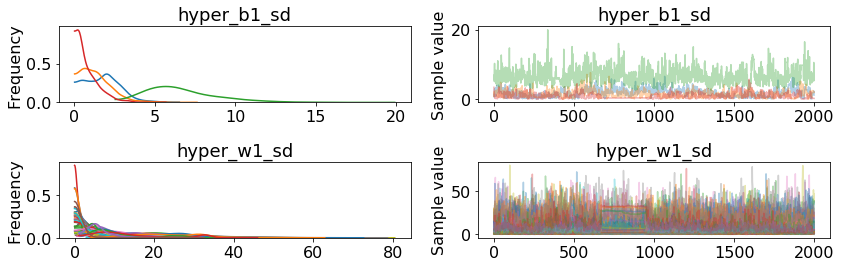

In [25]:
bnn_l2_4_4HL_411.evaluate_fit(['hyper_b1_sd', 
                               #'hyper_b2_sd', 
                               'hyper_w1_sd', #'hyper_w2_sd', 'hyper_w3_sd'
                              ]);

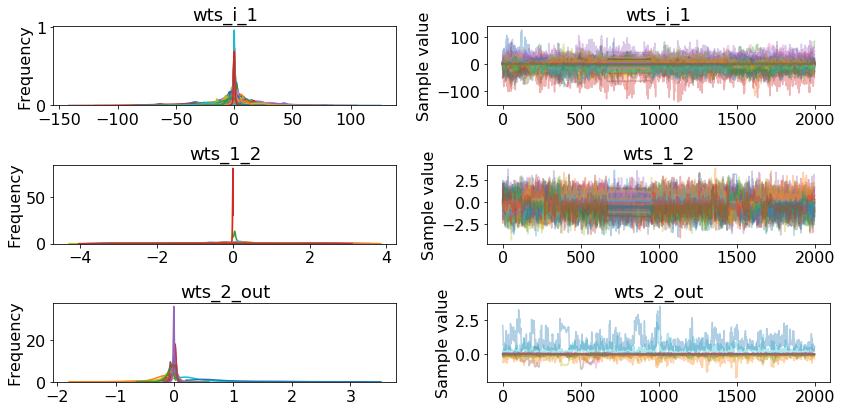

In [26]:
bnn_l2_4_4HL_411.evaluate_fit(['wts_i_1', 'wts_1_2', 'wts_2_out']);

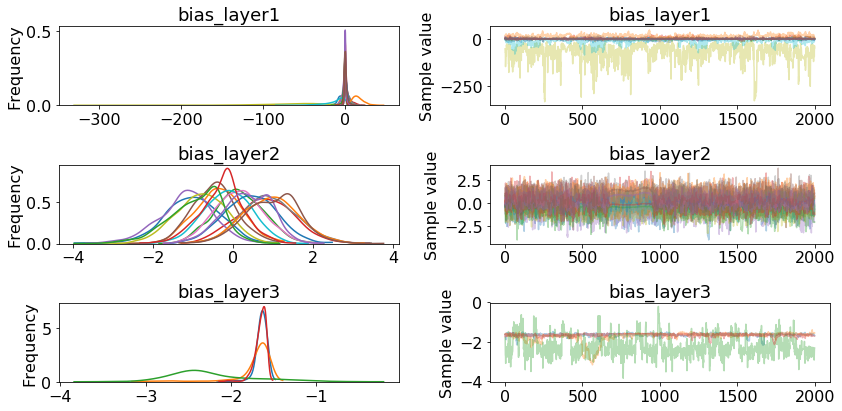

In [27]:
bnn_l2_4_4HL_411.evaluate_fit(['bias_layer1','bias_layer2', 'bias_layer3']);

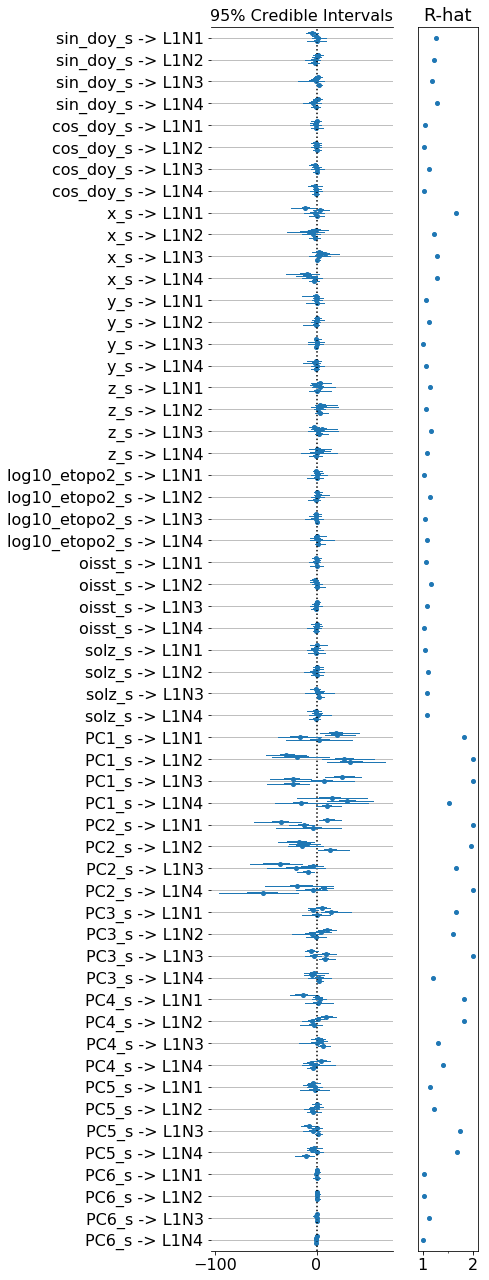

In [28]:
labels = ['%s -> L1N%d' %(li, ni) for li in lbls_X_s for ni in range(1, 5)]
bnn_l2_4_4HL_411.show_forest(['wts_i_1'], feat_labels=labels)
f = pl.gcf()
f.set_figheight(20);
f.savefig('./figJar/bnn_l2_4_4HL_411_wts_i_1_interp.pdf', dpi=300, format='pdf')

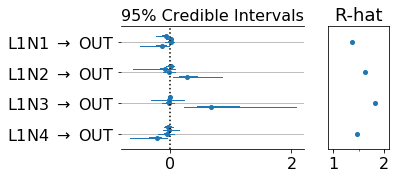

In [29]:
labels = [r'L1N%d $\rightarrow$ OUT' %ni for ni in range(1, 5)]
bnn_l2_4_4HL_411.show_forest(['wts_2_out'], feat_labels=labels)
f = pl.gcf()
f.set_figheight(2);

In [ ]:
from sklearn.metrics import 

In [37]:
ppc_train_l2_4_4HL_411.shape

(2000, 17)

In [38]:
X_shared.eval().shape

(145, 14)

100%|██████████| 2000/2000 [00:04<00:00, 475.09it/s]


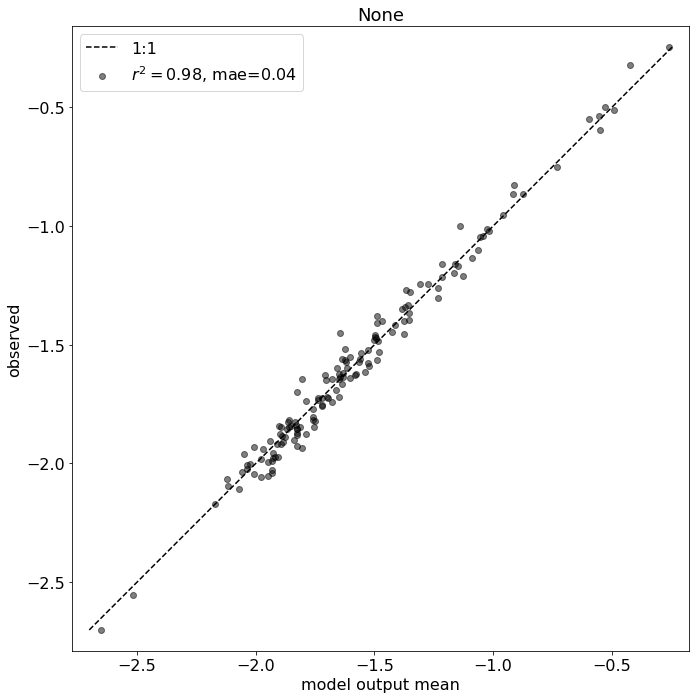

In [30]:
# Check fit on training model
X_shared.set_value(X_s_train)
ppc_train_l2_4_4HL_411 = bnn_l2_4_4HL_411.predict(likelihood_name='likelihood')
bnn_l2_4_4HL_411.plot_model_fits(y_train_all.log10_aphy411, ppc_train_l2_4_4HL_411, loss_metric='mae', );

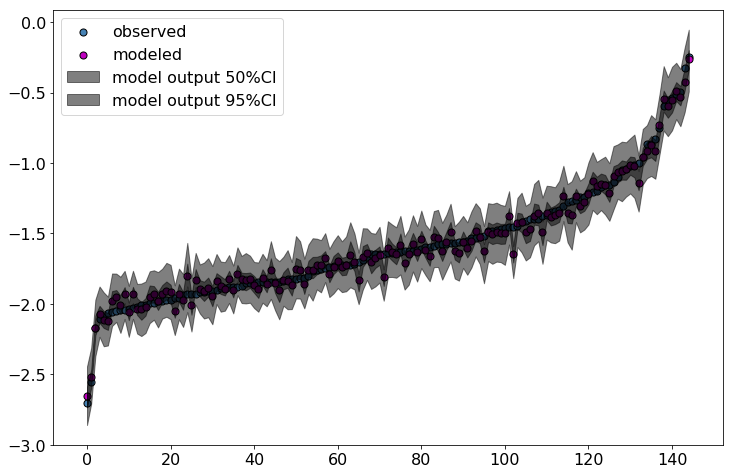

In [31]:
ax = plot_fits_with_unc(y_train_all.log10_aphy411, ppc_train_l2_4_4HL_411)

100%|██████████| 2000/2000 [00:04<00:00, 465.48it/s]


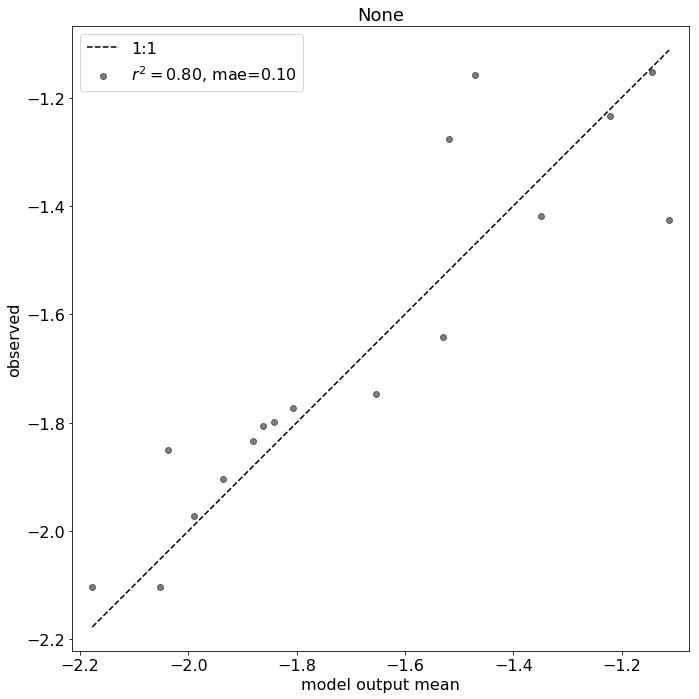

In [32]:
# Check Fit on Test Data
X_shared.set_value(X_s_test.values)
ppc_test_l2_4_4HL_411 = bnn_l2_4_4HL_411.predict(likelihood_name='likelihood')
bnn_l2_4_4HL_411.plot_model_fits(y_test_all.log10_aphy411, ppc_test_l2_4_4HL_411, loss_metric='mae',);

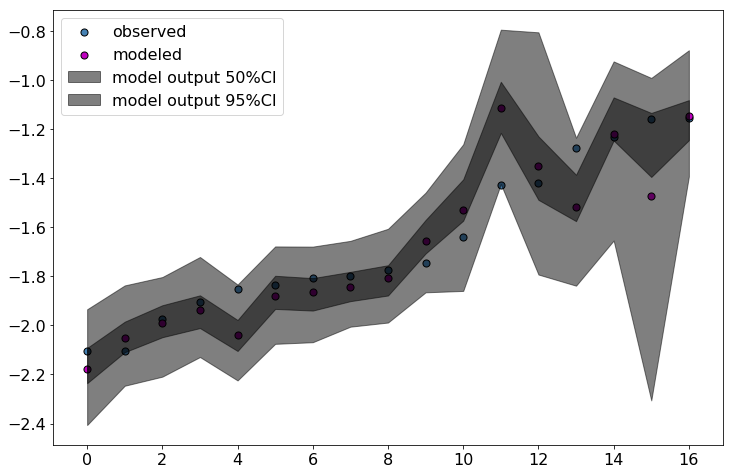

In [33]:
ax = plot_fits_with_unc(y_test_all.log10_aphy411, ppc_test_l2_4_4HL_411)

#### <u>Model 5: Double Layer -- 32-32 HL</u>

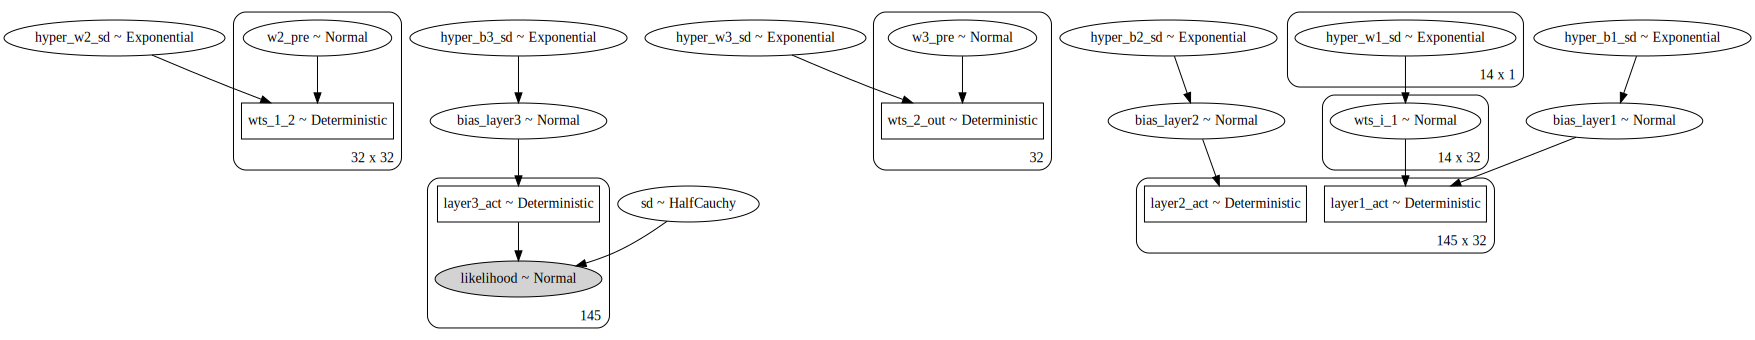

In [24]:
X_shared = shared(X_s_train.values)
bnn_l2_32_32HL_411 = PyMCModel(bayes_nn_l2, X_shared, y_train_all.log10_aphy411,
                           model_name='bnn_l2_HL_32_32_411',
                           n_hidden=(32,32))
bnn_l2_32_32HL_411.show_model()

In [26]:
X_shared.set_value(X_s_train)
bnn_l2_32_32HL_411.fit(tune=5000, cores=2, chains=1, nuts_kwargs=dict(max_treedepth=12))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sd, wts_i_1, w3_pre, w2_pre, bias_layer3, bias_layer2, bias_layer1, hyper_w3_sd, hyper_w2_sd, hyper_w1_sd, hyper_b3_sd, hyper_b2_sd, hyper_b1_sd]
100%|██████████| 7000/7000 [44:02<00:00,  2.65it/s]
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


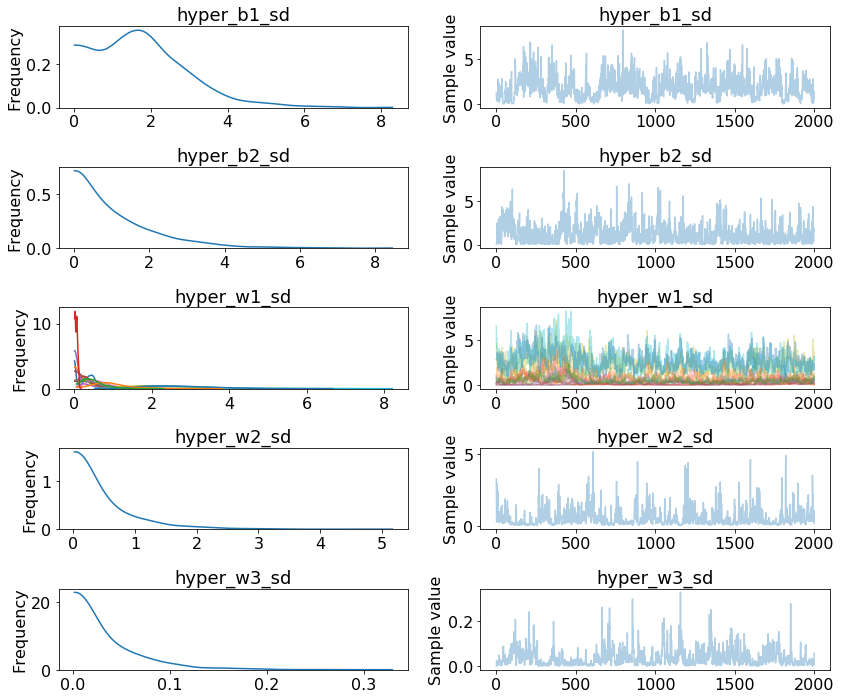

In [27]:
bnn_l2_32_32HL_411.evaluate_fit(['hyper_b1_sd', 'hyper_b2_sd', 'hyper_w1_sd', 'hyper_w2_sd', 'hyper_w3_sd']);

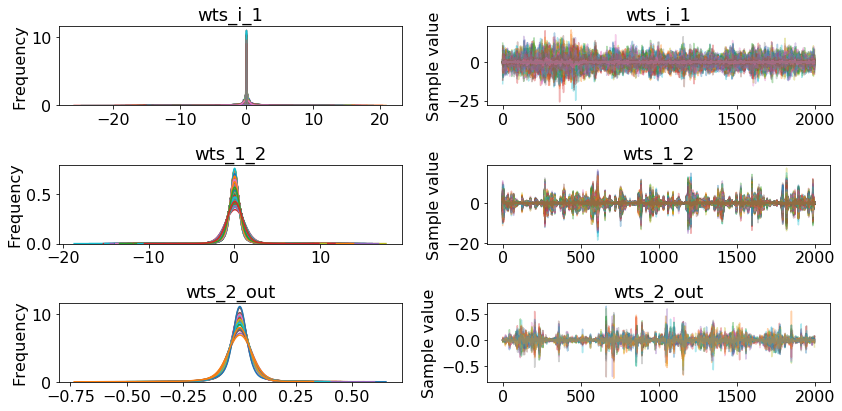

In [28]:
bnn_l2_32_32HL_411.evaluate_fit(['wts_i_1', 'wts_1_2', 'wts_2_out']);

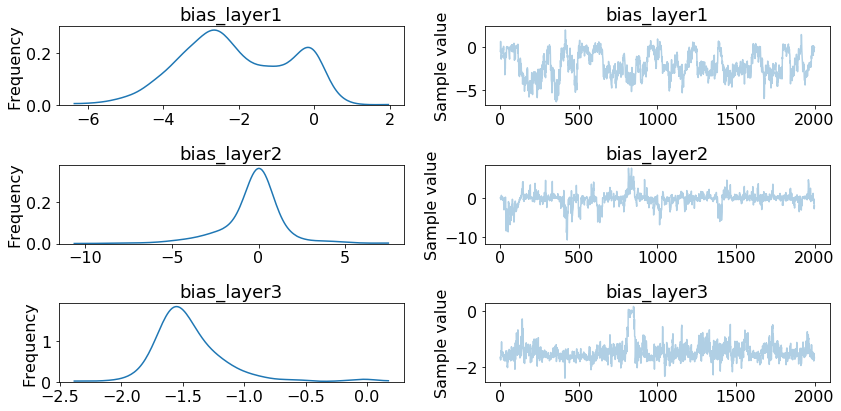

In [29]:
bnn_l2_32_32HL_411.evaluate_fit(['bias_layer1','bias_layer2', 'bias_layer3']);

100%|██████████| 2000/2000 [00:17<00:00, 115.53it/s]


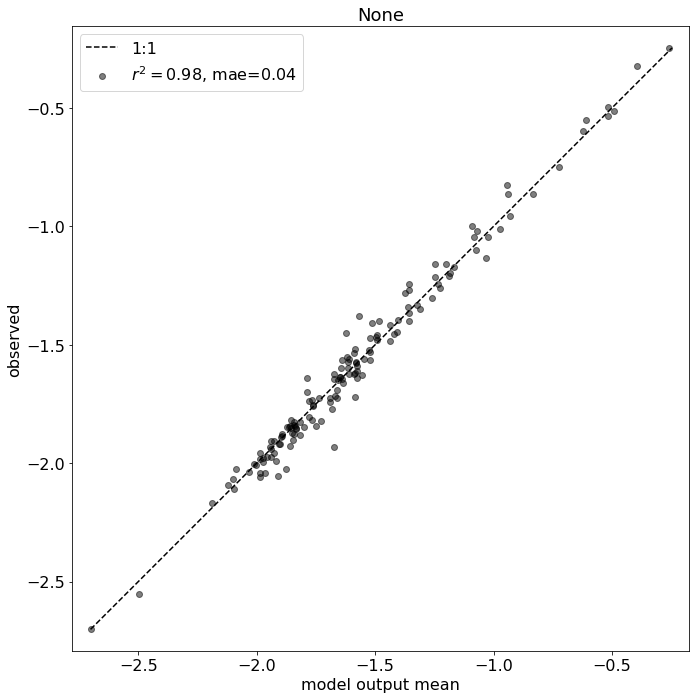

In [30]:
# Check fit on training model
ppc_train_l2_32_32HL_411 = bnn_l2_32_32HL_411.predict(likelihood_name='likelihood')
bnn_l2_32_32HL_411.plot_model_fits(y_train_all.log10_aphy411, ppc_train_l2_32_32HL_411, loss_metric='mae', );

100%|██████████| 2000/2000 [00:04<00:00, 456.99it/s]


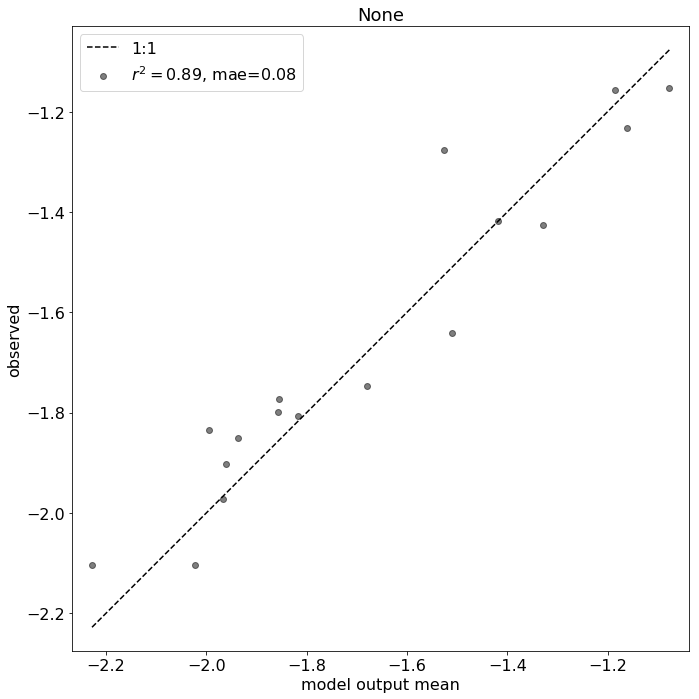

In [31]:
# Check Fit on Test Data
X_shared.set_value(X_s_test.values)
ppc_test_l2_32_32HL_411 = bnn_l2_32_32HL_411.predict(likelihood_name='likelihood')
bnn_l2_32_32HL_411.plot_model_fits(y_test_all.log10_aphy411, ppc_test_l2_32_32HL_411, loss_metric='mae',);

bnn_l2_4_4HL.model.name = 'bnn_l2_4_4HL'
bnn_l2_8_8HL.model.name = 'bnn_l2_8_8HL'
bnn_l2_8_8HL_robust.model.name= 'bnn_l2_8_8HL_r_NL'
bnn_l2_8_8HL_robust_s.model.name = 'bnn_l2_8_8HL_r_SL'

pickledModelDict = {bnn_l2.model.name: bnn_l2,
                   bnn_l2_8_8HL.model.name: bnn_l2_8_8HL,
                    bnn_l2_8_8HL_robust.model.name: bnn_l2_8_8HL_robust,
                    bnn_l2_8_8HL_robust_s.model.name: bnn_l2_8_8HL_robust_s,
                   }
with open('./pickleJar/Models/Aphi%d_BNN_2HL_ARD_SVGD.pkl' % band, 'wb') as f:
    pickle.dump(pickledModelDict, f, protocol=pickle.HIGHEST_PROTOCOL)